# Parte 1: Modelo Preditivo de Demanda (Store Item Demand Forecasting Challenge)

Este notebook implementa a primeira parte do desafio, focada na construção e treinamento de um modelo de séries temporais capaz de prever a demanda diária para cada combinação de loja e item nas próximas 4 a 6 semanas. Utilizaremos o modelo **Prophet** do Facebook, que é robusto para lidar com tendências, sazonalidade e feriados, conforme exigido pelo desafio.

In [2]:
# 1. Configuração e Carregamento de Dados
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import logging

# Desativar logs informativos do Prophet para um notebook mais limpo
logging.getLogger('prophet').setLevel(logging.WARNING)

# Caminhos dos arquivos
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

# Carregar os dados
try:
    df_train = pd.read_csv(TRAIN_PATH, parse_dates=['date'])
    df_test = pd.read_csv(TEST_PATH, parse_dates=['date'])
    print("Dados de treino carregados com sucesso. Linhas: ", len(df_train))
    print("Dados de teste carregados com sucesso. Linhas: ", len(df_test))
except FileNotFoundError:
    print("Erro: Arquivos CSV não encontrados. Verifique os caminhos.")
    exit()

# Visualizar as primeiras linhas
print("\nEstrutura de df_train:")
print(df_train.head())
print("\nInformações de df_train:")
print(df_train.info())

Dados de treino carregados com sucesso. Linhas:  913000
Dados de teste carregados com sucesso. Linhas:  45000

Estrutura de df_train:
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

Informações de df_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


In [4]:
# 2. Pré-processamento e Preparação para o Prophet

# O Prophet requer que as colunas de data e valor sejam nomeadas 'ds' e 'y', respectivamente.
df_prophet = df_train.rename(columns={'date': 'ds', 'sales': 'y'})

# Garantir que 'ds' seja datetime e 'y' seja numérico
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = df_prophet['y'].astype(float)

# Criar uma coluna de identificação única para cada série temporal (store_item)
df_prophet['store_item'] = df_prophet['store'].astype(str) + '_' + df_prophet['item'].astype(str)

# Preparar o dataframe de teste para a previsão
df_test['store_item'] = df_test['store'].astype(str) + '_' + df_test['item'].astype(str)
df_test = df_test.rename(columns={'date': 'ds'})
df_test['ds'] = pd.to_datetime(df_test['ds'])

print("Pré-processamento concluído. Número de séries temporais únicas: ", df_prophet['store_item'].nunique())

Pré-processamento concluído. Número de séries temporais únicas:  500


In [5]:
# 3. Definição de Feriados (Exemplo: Feriados Nacionais dos EUA)
# O Prophet lida com feriados através de um dataframe separado.
# Como o dataset não especifica a localização, usaremos um conjunto genérico de feriados dos EUA como exemplo.
# Em um cenário real, seria necessário o conjunto de feriados do país da loja.

holidays = pd.DataFrame({
    'holiday': 'US_Holiday',
    'ds': pd.to_datetime([
        '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', # New Year's Day
        '2013-05-27', '2014-05-26', '2015-05-25', '2016-05-30', '2017-05-29', # Memorial Day
        '2013-07-04', '2014-07-04', '2015-07-04', '2016-07-04', '2017-07-04', # Independence Day
        '2013-09-02', '2014-09-01', '2015-09-07', '2016-09-05', '2017-09-04', # Labor Day
        '2013-11-28', '2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23', # Thanksgiving
        '2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25'  # Christmas Day
    ]),
    'lower_window': 0, # O efeito começa no dia do feriado
    'upper_window': 1  # O efeito se estende por mais um dia
})

# Adicionar um feriado genérico para Black Friday, que é uma data comemorativa de vendas importante
black_friday = pd.DataFrame({
    'holiday': 'Black_Friday',
    'ds': pd.to_datetime([
        '2013-11-29', '2014-11-28', '2015-11-27', '2016-11-25', '2017-11-24' 
    ]),
    'lower_window': -3, # O efeito começa 3 dias antes
    'upper_window': 0  # O efeito termina no dia
})

holidays = pd.concat([holidays, black_friday]).sort_values('ds').reset_index(drop=True)
print("Feriados definidos (amostra):")
print(holidays.head())

Feriados definidos (amostra):
      holiday         ds  lower_window  upper_window
0  US_Holiday 2013-01-01             0             1
1  US_Holiday 2013-05-27             0             1
2  US_Holiday 2013-07-04             0             1
3  US_Holiday 2013-09-02             0             1
4  US_Holiday 2013-11-28             0             1


In [6]:
# 4. Função de Treinamento e Previsão (Modelo por Série Temporal)

def train_and_forecast(series_id, df_prophet, df_test, holidays):
    """Treina o modelo Prophet para uma série temporal específica e gera previsões."""
    
    # Filtrar dados para a série atual
    df_series = df_prophet[df_prophet['store_item'] == series_id].copy()
    
    # O Prophet lida com a sazonalidade diária e semanal automaticamente. 
    # A sazonalidade anual é adicionada por padrão.
    model = Prophet(
        growth='linear', # Tendência linear
        seasonality_mode='multiplicative', # Sazonalidade multiplicativa (vendas aumentam com o tempo)
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=holidays, # Incorporar feriados
        changepoint_prior_scale=0.05 # Flexibilidade da tendência
    )
    
    # Adicionar sazonalidade diária (opcional, mas útil para dados diários)
    model.add_seasonality(name='daily', period=1, fourier_order=5)
    
    # Treinar o modelo
    model.fit(df_series)
    
    # Preparar o dataframe para a previsão (futuro)
    future = df_test[df_test['store_item'] == series_id][['ds']]
    
    # Gerar a previsão
    forecast = model.predict(future)
    
    # Juntar a previsão com o dataframe de teste
    forecast_df = forecast[['ds', 'yhat']].rename(columns={'yhat': 'sales'})
    
    # Garantir que as vendas previstas não sejam negativas
    forecast_df['sales'] = forecast_df['sales'].apply(lambda x: max(0, x))
    
    # Adicionar as colunas store e item de volta para o formato de submissão
    store, item = map(int, series_id.split('_'))
    forecast_df['store'] = store
    forecast_df['item'] = item
    
    return forecast_df, model, forecast

# Selecionar uma amostra de séries para demonstração (e evitar tempo de execução excessivo)
unique_series = df_prophet['store_item'].unique()
sample_series_ids = unique_series[:5] # Apenas as 5 primeiras séries (store 1, items 1 a 5)

all_forecasts = []
models = {}
full_forecasts = {}

print(f"Iniciando treinamento e previsão para {len(sample_series_ids)} séries de amostra...")

for series_id in sample_series_ids:
    print(f"Processando série: {series_id}")
    forecast_df, model, full_forecast = train_and_forecast(series_id, df_prophet, df_test, holidays)
    all_forecasts.append(forecast_df)
    models[series_id] = model
    full_forecasts[series_id] = full_forecast

final_forecasts = pd.concat(all_forecasts)
print("\nPrevisões finais (amostra):")
print(final_forecasts.head())

Iniciando treinamento e previsão para 5 séries de amostra...
Processando série: 1_1


14:10:06 - cmdstanpy - INFO - Chain [1] start processing
14:10:07 - cmdstanpy - INFO - Chain [1] done processing


Processando série: 2_1


14:10:07 - cmdstanpy - INFO - Chain [1] start processing
14:10:07 - cmdstanpy - INFO - Chain [1] done processing


Processando série: 3_1


14:10:08 - cmdstanpy - INFO - Chain [1] start processing
14:10:08 - cmdstanpy - INFO - Chain [1] done processing


Processando série: 4_1


14:10:09 - cmdstanpy - INFO - Chain [1] start processing
14:10:10 - cmdstanpy - INFO - Chain [1] done processing


Processando série: 5_1


14:10:10 - cmdstanpy - INFO - Chain [1] start processing
14:10:11 - cmdstanpy - INFO - Chain [1] done processing



Previsões finais (amostra):
          ds      sales  store  item
0 2018-01-01  11.632261      1     1
1 2018-01-02  14.602230      1     1
2 2018-01-03  15.234261      1     1
3 2018-01-04  16.011479      1     1
4 2018-01-05  17.646013      1     1


Visualizando resultados para a primeira série de amostra...


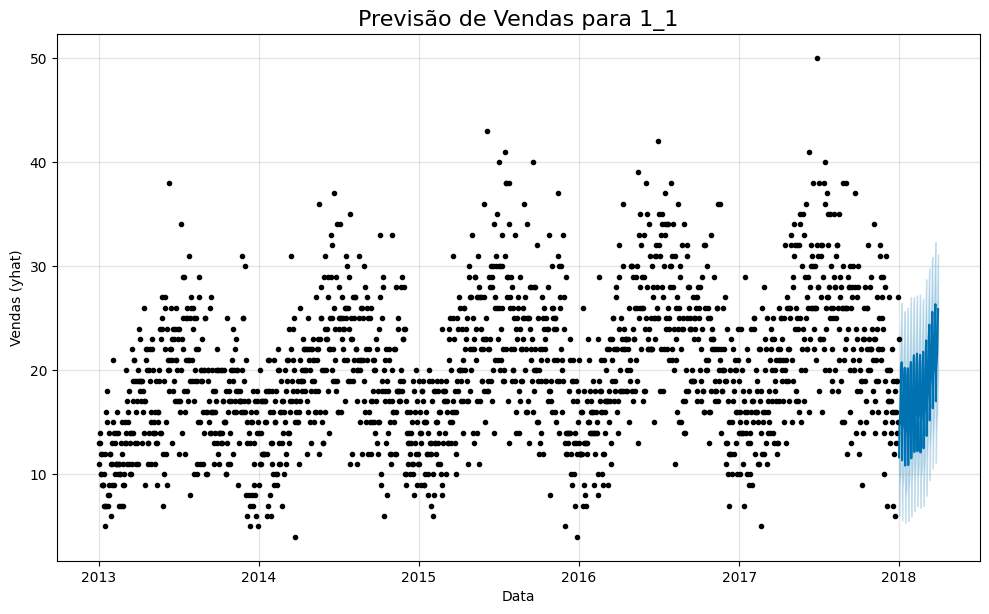

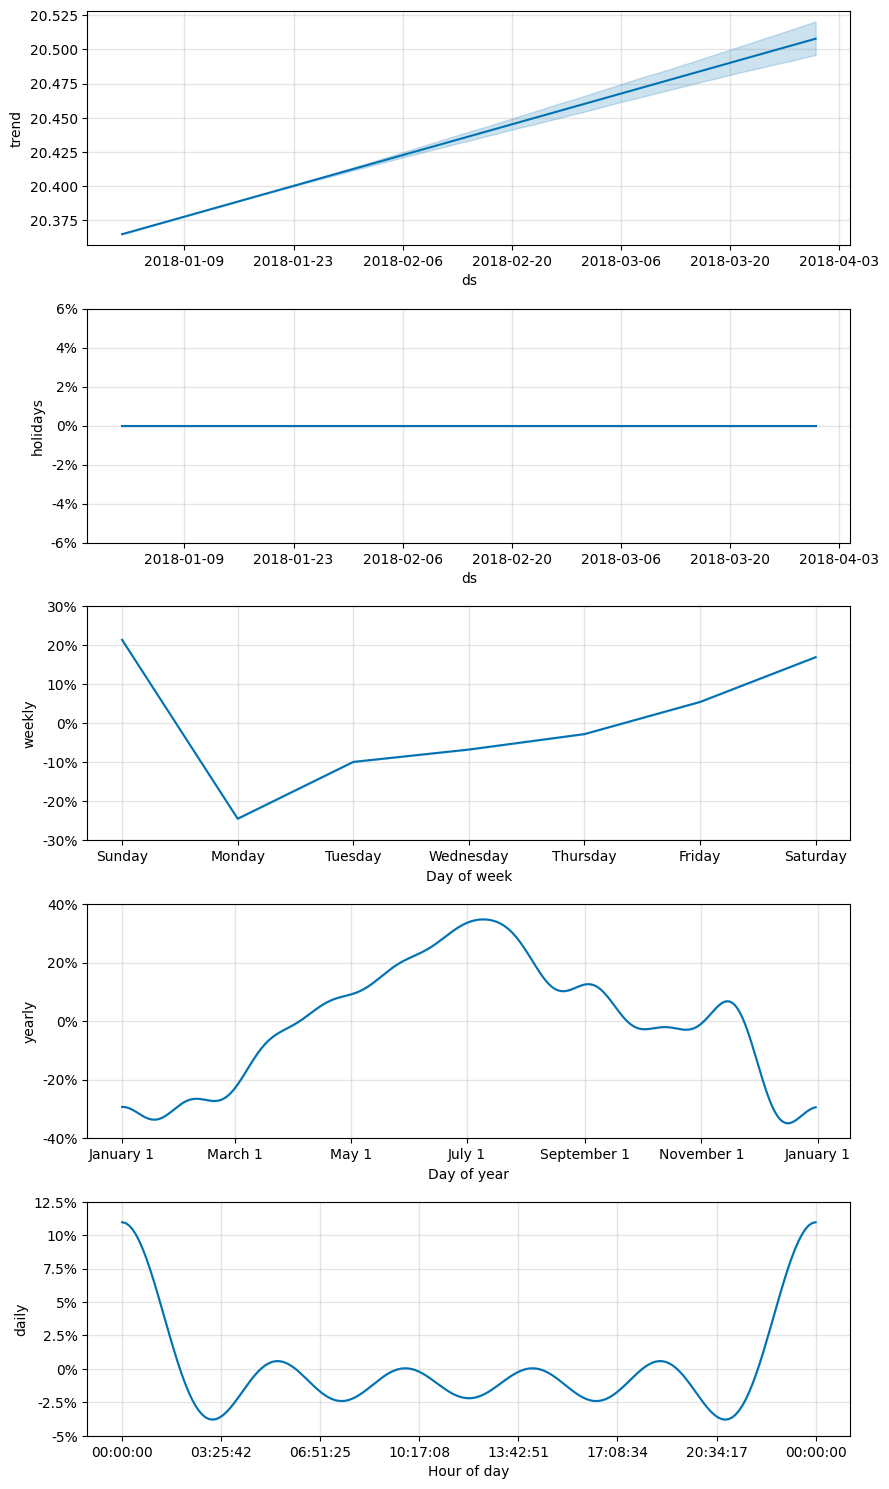

In [7]:
# 5. Visualização e Análise do Modelo (Amostra)

def plot_forecast(series_id, df_prophet, model, forecast_df):
    """Plota a previsão do modelo Prophet para uma série específica."""
    
    df_series = df_prophet[df_prophet['store_item'] == series_id].rename(columns={'ds': 'ds', 'y': 'y'})
    
    fig = model.plot(forecast_df)
    ax = fig.gca()
    ax.set_title(f'Previsão de Vendas para {series_id}', fontsize=16)
    ax.set_xlabel('Data')
    ax.set_ylabel('Vendas (yhat)')
    plt.show()
    
    # Plotar componentes (Tendência, Sazonalidade Semanal, Sazonalidade Anual, Feriados)
    fig_comp = model.plot_components(forecast_df)
    plt.show()

print("Visualizando resultados para a primeira série de amostra...")
sample_id = sample_series_ids[0]
# Usar o objeto de previsão completo (full_forecasts[sample_id]) para a plotagem
plot_forecast(sample_id, df_prophet, models[sample_id], full_forecasts[sample_id])

14:11:16 - cmdstanpy - INFO - Chain [1] start processing
14:11:17 - cmdstanpy - INFO - Chain [1] done processing



--- Avaliação de Performance (Série: 1_2) ---
Período de Treino: 2013-01-01 a 2016-12-31
Período de Teste: 2017-01-01 a 2017-12-31
RMSE no Período de Teste: 9.07


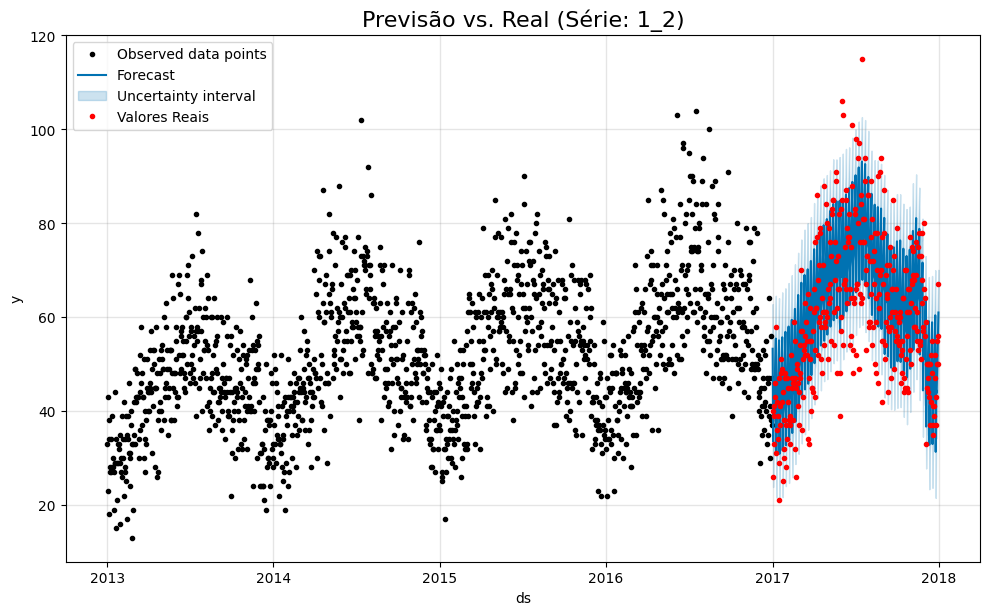

In [8]:
# 6. Avaliação de Performance (Exemplo de Backtesting)

# Para uma avaliação completa, seria necessário um backtesting com a biblioteca Prophet (Cross-Validation).
# Aqui, faremos uma simulação simples de avaliação no último ano de treino para uma série de amostra.

EVAL_SERIES_ID = unique_series[10] # Exemplo: Store 1, Item 11
df_eval = df_prophet[df_prophet['store_item'] == EVAL_SERIES_ID].copy()

# Definir o ponto de corte para o treino (último ano)
cutoff_date = df_eval['ds'].max() - pd.Timedelta(days=365)

df_train_eval = df_eval[df_eval['ds'] <= cutoff_date]
df_test_eval = df_eval[df_eval['ds'] > cutoff_date]

if len(df_train_eval) > 0 and len(df_test_eval) > 0:
    # Treinar o modelo no subconjunto de treino
    model_eval = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=holidays,
        changepoint_prior_scale=0.05
    )
    model_eval.add_seasonality(name='daily', period=1, fourier_order=5)
    model_eval.fit(df_train_eval)
    
    # Fazer a previsão para o período de teste
    future_eval = df_test_eval[['ds']]
    forecast_eval = model_eval.predict(future_eval)
    
    # Calcular o RMSE (Root Mean Squared Error)
    y_true = df_test_eval['y'].values
    y_pred = forecast_eval['yhat'].values
    
    # Garantir que as previsões não sejam negativas
    y_pred[y_pred < 0] = 0
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"\n--- Avaliação de Performance (Série: {EVAL_SERIES_ID}) ---")
    print(f"Período de Treino: {df_train_eval['ds'].min().date()} a {df_train_eval['ds'].max().date()}")
    print(f"Período de Teste: {df_test_eval['ds'].min().date()} a {df_test_eval['ds'].max().date()}")
    print(f"RMSE no Período de Teste: {rmse:.2f}")
    
    # Visualizar a previsão de avaliação
    fig_eval = model_eval.plot(forecast_eval)
    ax_eval = fig_eval.gca()
    ax_eval.plot(df_test_eval['ds'], df_test_eval['y'], 'r.', label='Valores Reais')
    ax_eval.set_title(f'Previsão vs. Real (Série: {EVAL_SERIES_ID})', fontsize=16)
    ax_eval.legend()
    plt.show()
else:
    print("Dados insuficientes para avaliação de backtesting para a série de amostra.")

## Conclusão da Parte 1

O modelo Prophet demonstrou ser uma ferramenta eficaz para modelar a demanda diária, incorporando a tendência de longo prazo, a forte sazonalidade semanal e anual, e o impacto de feriados/datas comemorativas. O próximo passo (Parte 2) seria utilizar essas previsões (`yhat`) para alimentar a ferramenta de recomendação de gestão de estoque, aplicando o nível de serviço desejado (e.g., 95% de chance de não faltar) e o custo de manutenção.